In [1]:
from models.recognition.model import OCRModel
from models.recognition.dataset import OCRVietnamese, DataLoader
from models.recognition.train import train_model
from models.recognition.utils import process_image
from models.recognition.vocab import Vocabulary
from models.recognition.loss import LabelSmoothingLoss

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import torch
import os

from configs.recognition_config import d_model, d_ff, num_heads, num_decoder_layers, dropout, learning_rate, weight_decay, maxlen

In [2]:
vocab = Vocabulary()
len(vocab)

227

In [3]:
data_path = './datasets/ocr_dataset/annotations.json'
import ujson
with open(data_path, 'r') as f:
    annotations = ujson.load(f)
len(annotations)

100000

In [ ]:
batch_size = 32

test_len = len(annotations)//10 # 10% test
train, test = torch.utils.data.random_split(annotations, [len(annotations)-test_len, test_len])

train_dataset = OCRVietnamese(train, vocab, process_image, maxlen)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = OCRVietnamese(test, vocab, process_image, maxlen)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

len(train), len(test)

(90000, 10000)

In [5]:
model = OCRModel(
    vocab_size=len(vocab),
    d_model = d_model,
    num_heads = num_heads,
    d_ff = d_ff,
    num_decoder_layers = num_decoder_layers,
    dropout = dropout
)

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = LabelSmoothingLoss(classes=len(vocab), padding_idx=0)

/Users/hung/Desktop/OCR/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hung/Desktop/OCR/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
epochs = 10

In [ ]:
model_name = f'model_weights-{epochs}'
if os.path.exists(f'./checkpoints/recognition/{model_name}.pth'):
    state_dict = torch.load(f'./checkpoints/recognition/{model_name}.pth')
    model.load_state_dict(state_dict)
else:
    train_model(model, test_loader, optimizer, criterion, vocab, epochs)
    torch.save(model.state_dict(), f'./checkpoints/recognition/{model_name}.pth')

  0%|          | 0/2813 [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [3, 32, 256] at entry 0 and [3, 32, 90] at entry 1

In [ ]:
# from models.recognition.eval import evaluate
# device = 'cpu'
# avg_loss, acc = evaluate(model, test_loader, criterion, device, vocab)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluation - Avg Loss: 1.1837, Character Accuracy: 0.0000


# infer

In [ ]:
#! vấn đề là resize ảnh để giữ kích thước + dùng được resnet

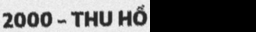

(256, 32)

In [ ]:
# from PIL import Image
# _, _, path = test_dataset.get_random_image()
# # path ='./datasets/ocr_dataset/vi_00/65116.jpg'
# image = Image.open(path)
# p_image = process_image(image, 32, 32, 256)

# display(p_image)
# p_image.size

actual:  Bí Thư: Chính Ủy Học Viện
generated:  Ba Tha Tha Tha Tra Tha Tha Tha Tha Tha Tra Tha Tha Th Tha Tha Tra Tra Tra Tra Tra Tra Tra Tra Tra T


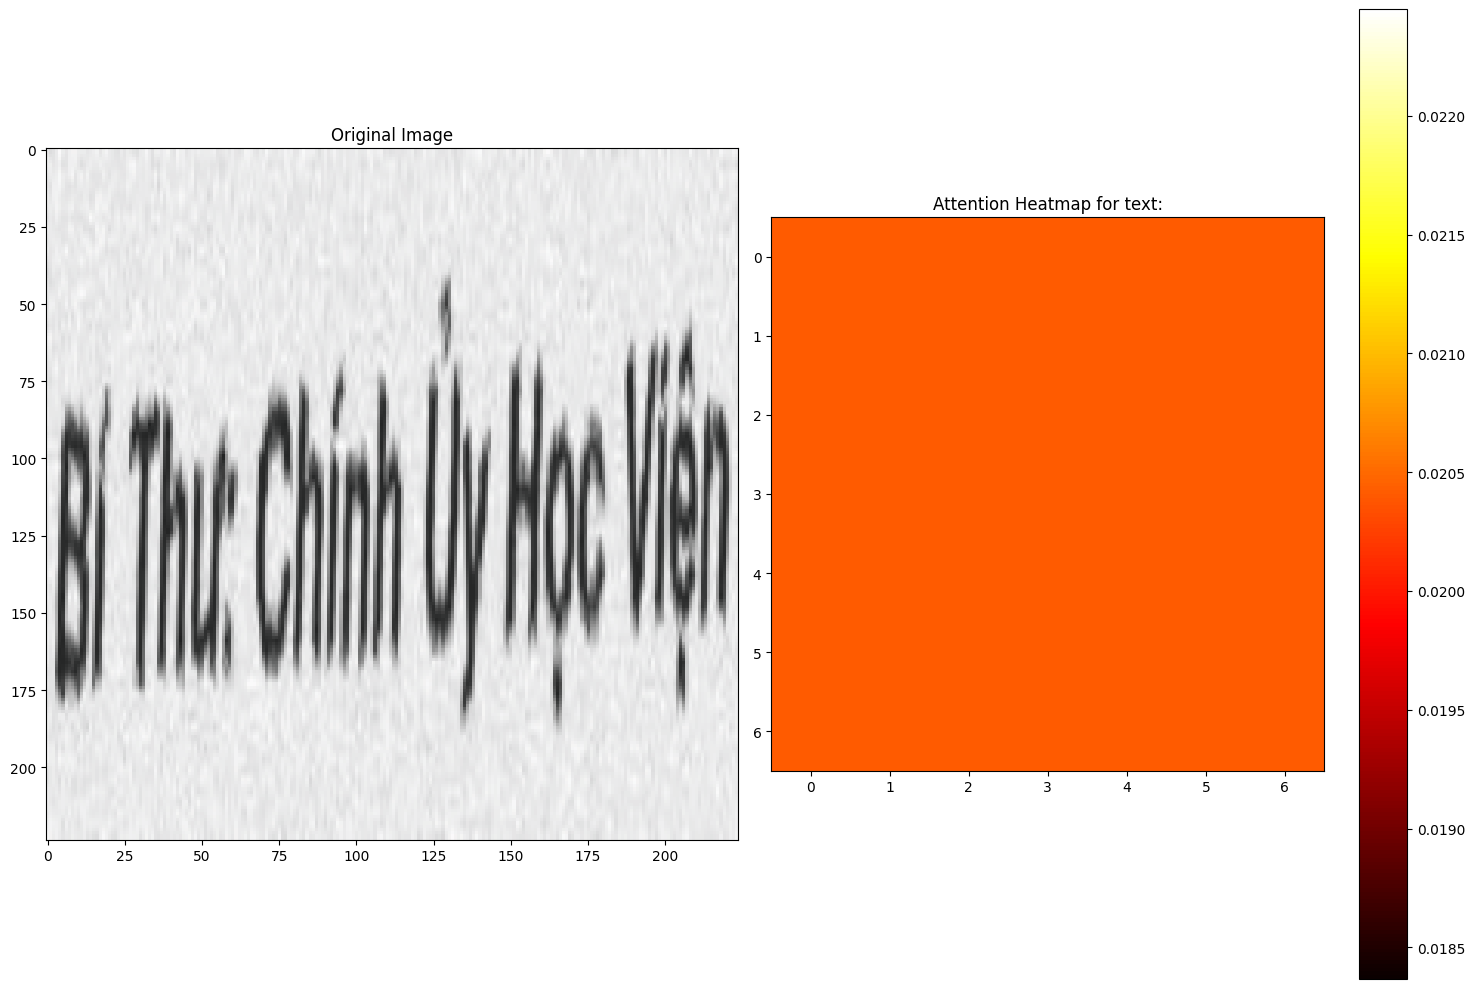

In [ ]:
img, txt, path = test_dataset.get_random_image()

model = model.to('cpu')
image = img.to('cpu')

pred_txt, f ,a  = model.generate_text(image.unsqueeze(0), vocab)
model.visualize_attention(img, txt, pred_txt[0], f, a)